# Tic-Tac-Toe

Aswin van Woudenberg (https://www.aswinvanwoudenberg.com | https://github.com/afvanwoudenberg)

## Introduction

This notebook implements various agents for the game of Tic-Tac-Toe. 

## Import libraries

We start by importing some libraries.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipywidgets as widgets
import math
import random

from matplotlib.backend_bases import MouseButton
from enum import Enum, auto

## Some userful enums

We define a Player enum that represents the player.

In [2]:
class Player(Enum):
    X=auto()
    O=auto()

And a PlayerType enum.

In [3]:
class PlayerType(Enum):
    HUMAN=auto()
    MACHINE=auto()

## Tic-Tac-Toe class

We create a class that encapsulates the rules and gameplay. The render method uses the matplotlib library to show a tic-tac-toe board. By binding event handlers we can make the board interactive.

In [4]:
class TicTacToe():
    def __init__(self):
        self.board = [None] * 9
    
    def get_moves(self):
        if self.get_winner():
            return []
        return [i for (i, m) in enumerate(self.board) if m == None]

    def get_current_player(self):
        if self.get_moves():
            return Player.O if self.board.count(None) % 2 == 0 else Player.X
        return None
    
    def __get_winner_line(self, a, b, c):
        if self.board[a] and self.board[a] == self.board[b] and self.board[b] == self.board[c]:
            return self.board[a]
        else:
            return None
    
    def get_winner(self):
        for i in range(3):
            if self.__get_winner_line(i*3,i*3+1,i*3+2):
                return self.board[i*3]
            if self.__get_winner_line(i,3+i,6+i):
                return self.board[i]
        if self.__get_winner_line(0,4,8):
            return self.board[0]
        if self.__get_winner_line(2,4,6):
            return self.board[2]
        return None
    
    def step(self, index):
        if index in self.get_moves():
            self.board[index] = self.get_current_player()
        else:
            raise ValueError("Invalid move")
    
    def undo(self, index):
        self.board[index] = None
            
    def reset(self):
        self.board = [None] * 9
    
    def __get_plot_coords(self):
        x_vals_x = []
        y_vals_x = []
        x_vals_o = []
        y_vals_o = []
        for i, v in enumerate(self.board):
            if v == Player.X:
                y, x = divmod(i, 3)
                x_vals_x.append(x)
                y_vals_x.append(y)
            elif v == Player.O:
                y, x = divmod(i, 3)
                x_vals_o.append(x)
                y_vals_o.append(y)

        return x_vals_x, y_vals_x, x_vals_o, y_vals_o
    
    def render(self):
        x_vals_x, y_vals_x, x_vals_o, y_vals_o = self.__get_plot_coords()
        plt.clf()
        
        if self.get_winner() == Player.X:
            plt.title("X wins!")
        elif self.get_winner() == Player.O:
            plt.title("O wins!")
        else:
            if self.get_current_player() == Player.X:
                plt.title("X's turn")
            elif self.get_current_player() == Player.O:
                plt.title("O's turn")
            else:
                plt.title("It's a tie")
        
        fig = plt.gca()
        M = fig.transData.get_matrix()
        scale = min(M[0,0], M[1,1])
        markersize = (scale * 0.15)**2
        
        plt.scatter(x_vals_o, y_vals_o, s=markersize, facecolors='none', edgecolors='red', marker='o')
        plt.scatter(x_vals_x, y_vals_x, s=markersize, facecolors='blue', marker='x')
        plt.xlim(-1, 3)
        plt.ylim(-1, 3)
        
        fig.set_aspect('equal')
        plt.axis('off')
        plt.plot([1.5, 1.5], [-0.5, 2.5], 'black')
        plt.plot([0.5, 0.5], [-0.5, 2.5], 'black')
        plt.plot([-0.5, 2.5], [1.5, 1.5], 'black')
        plt.plot([-0.5, 2.5], [0.5, 0.5], 'black')
        
        for i in range(3):
            if self.__get_winner_line(i*3,i*3+1,i*3+2):
                plt.plot([-0.25, 2.25], [i, i], 'black', linewidth=15, alpha=0.3, solid_capstyle='round')
            if self.__get_winner_line(i,3+i,6+i):
                plt.plot([i, i], [-0.25, 2.25], 'black', linewidth=15, alpha=0.3, solid_capstyle='round')
        if self.__get_winner_line(0,4,8):
            plt.plot([-0.25, 2.25], [-0.25, 2.25], 'black', linewidth=15, alpha=0.3, solid_capstyle='round')
        if self.__get_winner_line(2,4,6):
            plt.plot([-0.25, 2.25], [2.25, -0.25], 'black', linewidth=15, alpha=0.3, solid_capstyle='round')
        
        plt.draw()

## AI agents

We let the user play against three different algorithms:

* Random moves
* Minimax with $\alpha\beta$-pruning
* Monte Carlo sampling

### Random agent

The following code returns a random move.

In [5]:
def random_move(state):
    return random.choice(state.get_moves())

## Minimax with $\alpha\beta$ pruning

We can use minimax with $\alpha\beta$ pruning to implement our AI. Because the game tree only goes at most 9 plies deep we always search until the end. This way our evaluation function can be very simple and simply returns +inf if the player ends up winning, -inf if the player ends up losing, and 0 otherwise.

In [6]:
def eval(state, player):
    if not state.get_winner():
        return 0
    elif state.get_winner() == player:
        return math.inf
    else:
        return -math.inf

The minimax algorithm below shuffles the list of possible moves to create some variation in the moves it makes.

In [7]:
def alpha_beta_(state, ply, player, opponent, alpha, beta):
    if ply == 0:
        return None, eval(state, player)
    
    moves = state.get_moves()
    if not moves:
        return None, eval(state, player)
    random.shuffle(moves)
    
    best = None, alpha
    for move in moves:
        state.step(move)
        move_eval = alpha_beta_(state, ply-1, opponent, player, -beta, -alpha)
        state.undo(move)
        
        if -move_eval[1] > alpha:
            alpha = -move_eval[1]
            best = move, alpha
        if alpha >= beta:
            return best
    return best

def alpha_beta(state, ply=9):
    player = state.get_current_player()
    opponent = Player.O if player == Player.X else Player.X

    return alpha_beta_(state, ply, player, opponent, -math.inf, math.inf)[0]

One disadvantage of using minimax is that the algorithm assumes that the opponent doesn't make mistakes. In Tic-Tac-Toe, if neither player ever makes a mistake it doesn't matter what the first move is. The game will always end in a draw. 

## Monte Carlo sampling

Another alternative would be to use Monte Carlo sampling. The general idea behind this approach is to play a set of games with random moves starting from the current position, and then use the results of these games to compute a good move. When a machine player wins one of these random games, it wants to favor the squares in which it played and avoid the squares in which the opponent played. Conversely, when it loses one of these random games, it wants to favor the squares in which the opponent played (to block the opponent) and avoid the squares in which it played.

In [8]:
MC_MATCH = 1
MC_OTHER = 1

def mc_trials(state, n_trials):
    scores = [0] * 9
    player = state.get_current_player()
    opponent = Player.O if player == Player.X else Player.X
    board = state.board.copy() # backup old state
    
    for i in range(9):
        if state.board[i]:
            scores[i] = -math.inf # Set all occupied squares to -∞        
    
    for _ in range(n_trials):        
        moves = state.get_moves()
        while moves:
            move = random.choice(moves)
            state.step(move)
            moves = state.get_moves()
        
        winner = state.get_winner()
        if winner == player:
            for i in range(9):
                if not board[i] and state.board[i]:
                    if state.board[i] == player:
                        scores[i] += MC_MATCH
                    else:
                        scores[i] -= MC_OTHER
        elif winner == opponent:
            for i in range(9):
                if not board[i] and state.board[i]:
                    if state.board[i] == player:
                        scores[i] -= MC_MATCH
                    else:
                        scores[i] += MC_OTHER
        
        state.board = board.copy() # restore state
    
    return scores.index(max(scores))

mc_trials10 = lambda state: mc_trials(state, 10)
mc_trials100 = lambda state: mc_trials(state, 100)
mc_trials500 = lambda state: mc_trials(state, 500)
mc_trials1000 = lambda state: mc_trials(state, 1000)

The disadvantage of this algorithm is that it doesn't favor ending in a draw over losing.

## A user interface

We use matplotlib to visualize the board. We handle button press and resize events. Every time a game is finished we switch sides with the computer.

In [9]:
player_types = [PlayerType.HUMAN, PlayerType.MACHINE]

Create an instance of the TicTacToe class.

In [10]:
game = TicTacToe()

We create a dictionary of possible agents the user can select from.

In [11]:
agents = {
    "Random": random_move,
    "Monte Carlo (10 trials)": mc_trials10,
    "Monte Carlo (100 trials)": mc_trials100,
    "Monte Carlo (500 trials)": mc_trials500,
    "Monte Carlo (1000 trials)": mc_trials1000,
    "Minimax with αβ-pruning": alpha_beta    
}

The user can select the agent it wishes to compete with from a dropdown widget.

In [12]:
agent_dropdown = widgets.Dropdown(
    options=list(agents.keys()), 
    value="Minimax with αβ-pruning", 
    description='Agent:'
)

In [13]:
def on_plt_click(event):
    if event.button == 1:
        index = int(round(event.ydata, 0) * 3 + round(event.xdata, 0))
        if game.get_moves():
            game.step(index)
        else:
            game.reset()
            player_types.reverse()
        game.render()
        if game.get_moves() and player_types[(len(game.get_moves()) + 1) % 2] == PlayerType.MACHINE:
            move = agents[agent_dropdown.value](game)
            game.step(move)
            game.render()

In [14]:
def on_plt_resize(event):
    game.render()

Dropdown(description='Agent:', index=5, options=('Random', 'Monte Carlo (10 trials)', 'Monte Carlo (100 trials…

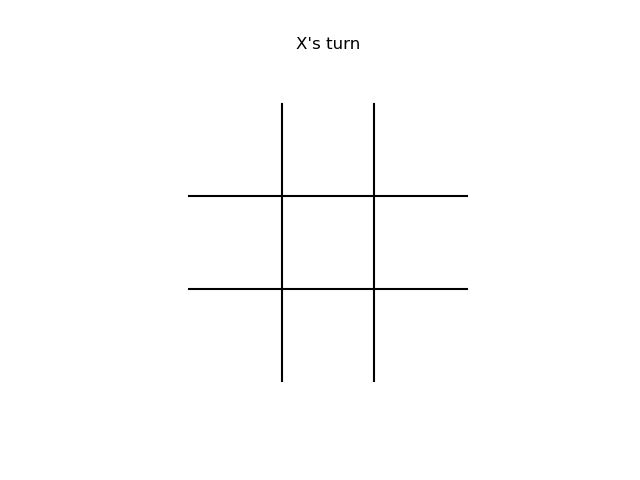

In [15]:
display(agent_dropdown)

fig = plt.figure("Tic-Tac-Toe")
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False

game.render()

plt.connect('button_press_event', on_plt_click)
plt.connect('resize_event', on_plt_resize)

plt.show()

Click an empty square to make a move. Once a game is finished click the board to start a new game. After each round you and the computer switch places.